In [281]:
import librosa
import numpy as np
import os
import pandas as pd
import soundfile
import sys
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 
from librosa import display   

%matplotlib inline

We define a function that takes a set of features per time frame and stack the mean so that the data becomes 1-Dimension.

In [282]:
def feature_to_1d(features):
    result = np.array([])
    mfcc = np.mean(features.T, axis=0)
    result = np.hstack((result, mfcc))
    return result

We import the binary files containing the original features (MFCCs, and Mel-Spectrogram) in 2D form, as well as the labels corresponding to each feature set.

In [283]:
#mel

f = open('IEMOCAP_Data/Data_10_sec/X_train_mel', 'rb')
X_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/X_test_mel', 'rb')
X_test_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_train_mel', 'rb')
y_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_test_mel', 'rb')
y_test_mel = joblib.load(f)
f.close()

#mfcc

f = open('IEMOCAP_Data/Data_10_sec/X_train_mfcc', 'rb')
X_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/X_test_mfcc', 'rb')
X_test_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_train_mfcc', 'rb')
y_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_test_mfcc', 'rb')
y_test_mfcc = joblib.load(f)
f.close()

### Converting to 1D Data

We convert the 2D features to 1D data.

In [284]:
X_train_mel_1d = []
X_test_mel_1d = []
X_train_mfcc_1d = []
X_test_mfcc_1d = []

In [285]:
for i in range(len(X_train_mel)):
    X_train_mel_1d.append(feature_to_1d(X_train_mel[i]))
for i in range(len(X_test_mel)):
    X_test_mel_1d.append(feature_to_1d(X_test_mel[i]))
for i in range(len(X_train_mfcc)):
    X_train_mfcc_1d.append(feature_to_1d(X_train_mfcc[i]))
for i in range(len(X_test_mfcc)):
    X_test_mfcc_1d.append(feature_to_1d(X_test_mfcc[i]))

In [286]:
X_train_mel = np.array(X_train_mel_1d)
X_test_mel = np.array(X_test_mel_1d)
X_train_mfcc = np.array(X_train_mfcc_1d)
X_test_mfcc = np.array(X_test_mfcc_1d)

In [287]:
X_train_mel.shape

(2100, 128)

In [288]:
X_train_mfcc.shape

(2100, 40)

Split data into train and test set per feature.

### Transform the y data 

We transform the y data containing the labels into onehot-encoded form so that the models can classify the categorical accuracy and loss.

In [289]:
y_onehot_train_mel = y_train_mel
y_onehot_test_mel = y_test_mel

y_onehot_train_mfcc = y_train_mfcc
y_onehot_test_mfcc = y_test_mfcc

In [290]:
y_onehot_train_mel = pd.get_dummies(y_onehot_train_mel)
y_onehot_test_mel = pd.get_dummies(y_onehot_test_mel)

y_onehot_train_mfcc = pd.get_dummies(y_onehot_train_mfcc)
y_onehot_test_mfcc = pd.get_dummies(y_onehot_test_mfcc)

In [291]:
y_onehot_train_mel = np.asarray(y_onehot_train_mel).astype('int8')
y_onehot_test_mel  = np.asarray(y_onehot_test_mel).astype('int8')

y_onehot_train_mfcc = np.asarray(y_onehot_train_mfcc).astype('int8')
y_onehot_test_mfcc  = np.asarray(y_onehot_test_mfcc).astype('int8')

Import libraries needed for defining the models.

In [292]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, GlobalMaxPooling1D, Concatenate, BatchNormalization, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

In [293]:
X_train_mfcc.shape

(2100, 40)

Expand the dimensions for the training and testing data so that it can be used for the neural networks.

In [294]:
X_traincnn_mfcc = np.expand_dims(X_train_mfcc, axis = 2)
X_testcnn_mfcc = np.expand_dims(X_test_mfcc, axis = 2)
X_traincnn_mel = np.expand_dims(X_train_mel, axis = 2)
X_testcnn_mel = np.expand_dims(X_test_mel, axis = 2)

#### We define some functions for training and testing

In [295]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [296]:
checkpoint_path = 'IEMOCAP_Data/Weights/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

#### MFCC

We use MFCC as input features.

In [297]:
print(X_train_mfcc_np.shape)
print(X_test_mfcc_np.shape)
print(y_onehot_train_mfcc.shape)
print(y_onehot_test_mfcc.shape)

(2100, 40)
(900, 40)
(2100, 6)
(900, 6)


In [298]:
X_train_mfcc_np = np.array(X_train_mfcc)
X_test_mfcc_np = np.array(X_test_mfcc)
y_train_mfcc_np = np.array(y_train_mfcc)
y_test_mfcc_np = np.array(y_test_mfcc)

In [299]:
X_test_mfcc_np.shape

(900, 40)

# Results using Machine Learning algorithms

In this section of the notebook, we perform experiments on the data we have using traditional Machine Learning algorithms. We define a set of functions to visualize the performance of each ML model.

In [300]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    print(num_classes)
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(fbeta_score(y_test, pred, beta= 1.0,average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

## MFCC

In this section, we use MFCCs as input for the ML models.

#### Random Forest Classifier

6
Test Set Accuracy =  0.733
Test Set F-score =  0.719
Test Set Precision =  0.716
Test Set Recall =  0.729
Confusion matrix, without normalization
[[119   6   2   0   2   1]
 [ 25  75  17   0   5  31]
 [ 13  20  65   0   2  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 11  26  31   0   4  78]]


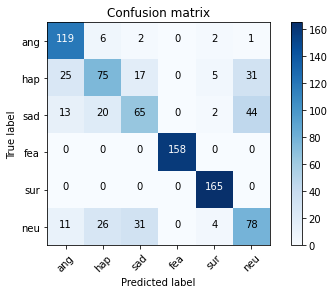

In [41]:
## Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=50, min_samples_split=10)
rf_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = rf_classifier.predict_proba(X_test_mfcc)
# Results
display_results(y_test_mfcc, pred_probs)

#### XGB Classifier

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:11] WARNING: ../src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.700
Test Set F-score =  0.681
Test Set Precision =  0.676
Test Set Recall =  0.696
Confusion matrix, without normalization
[[117   7   4   0   2   0]
 [ 27  64  20   0  10  32]
 [ 13  22  58   1   4  46]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  32  31   1   6  68]]


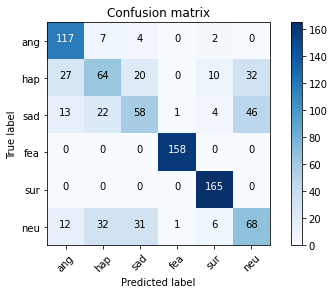

In [42]:
## XGB Classifier
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.005, objective='multi:softprob', 
                                   n_estimators=100, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=5)
xgb_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = xgb_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

#### MLP Classifier

6
Test Set Accuracy =  0.454
Test Set F-score =  0.407
Test Set Precision =  0.695
Test Set Recall =  0.448
Confusion matrix, without normalization
[[ 22  21  80   3   4   0]
 [  3  38  96   4  12   0]
 [  3   5 130   3   3   0]
 [  0   0   0 158   0   0]
 [  0   7  92   6  60   0]
 [  0   3 141   2   3   1]]


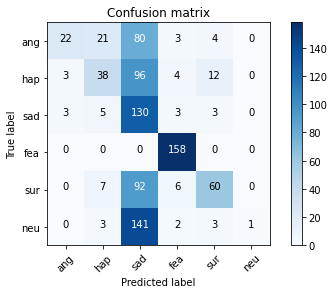

In [130]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)


## best activation


6
Test Set Accuracy =  0.469
Test Set F-score =  0.381
Test Set Precision =  0.444
Test Set Recall =  0.457
Confusion matrix, without normalization
[[ 25  19  36  16  34   0]
 [  3  20  54  12  64   0]
 [  2   4 104  13  21   0]
 [  0   0   0 158   0   0]
 [  0   0  26  24 115   0]
 [  1   2  97  20  30   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


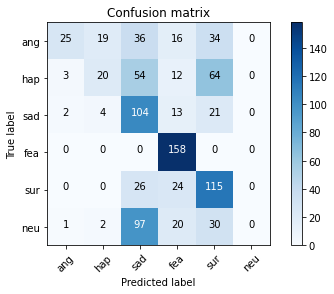

In [43]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)


6
Test Set Accuracy =  0.457
Test Set F-score =  0.441
Test Set Precision =  0.552
Test Set Recall =  0.449
Confusion matrix, without normalization
[[ 32  10  13   1  17  57]
 [  6   9  20   2  41  75]
 [  4   2  64   0  13  61]
 [  0   0   0 113   0  45]
 [  4   0   5   0  91  65]
 [  1   0  28   3  16 102]]


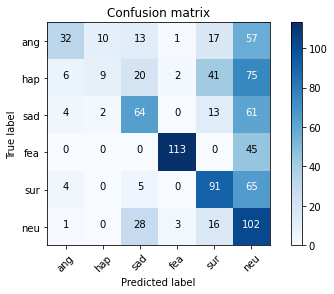

In [44]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='identity', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)


6
Test Set Accuracy =  0.732
Test Set F-score =  0.716
Test Set Precision =  0.723
Test Set Recall =  0.729
Confusion matrix, without normalization
[[117   2  10   0   0   1]
 [ 26  55  35   0   9  28]
 [ 11  11  79   0   4  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  14  39   1   4  85]]


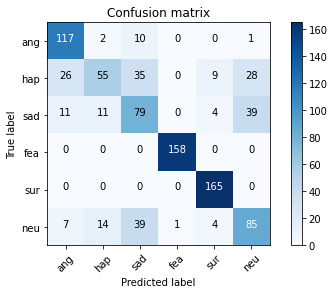

In [45]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)


6
Test Set Accuracy =  0.663
Test Set F-score =  0.645
Test Set Precision =  0.645
Test Set Recall =  0.656
Confusion matrix, without normalization
[[ 90  22   5   0   6   7]
 [ 42  62  17   2  13  17]
 [ 22  15  57   1   5  44]
 [  0   0   0 158   0   0]
 [  0   6   4   0 152   3]
 [ 15  19  21   1  16  78]]


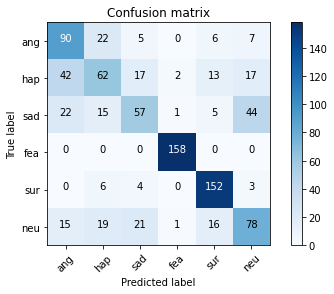

In [201]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='tanh', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)


## best solver

6
Test Set Accuracy =  0.719
Test Set F-score =  0.706
Test Set Precision =  0.702
Test Set Recall =  0.712
Confusion matrix, without normalization
[[102   9  11   0   0   8]
 [ 19  84  22   0   9  19]
 [ 10  27  64   0   2  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  28  31   1   8  74]]


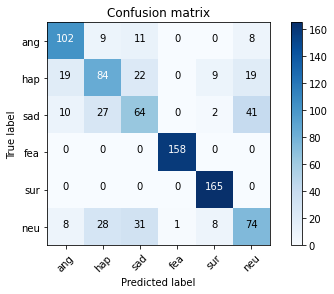

In [171]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6
Test Set Accuracy =  0.561
Test Set F-score =  0.549
Test Set Precision =  0.549
Test Set Recall =  0.558
Confusion matrix, without normalization
[[ 84  18   2   2  11  13]
 [ 38  47  13   2  26  27]
 [ 19  12  57   5  10  41]
 [  0   0   0 158   0   0]
 [  7   8  17   4 102  27]
 [ 16  13  48   1  15  57]]


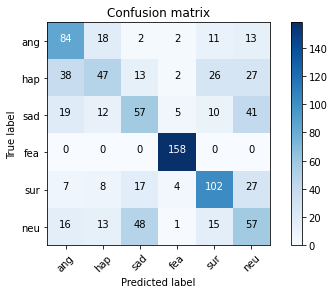

In [172]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='lbfgs', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.160
Test Set F-score =  0.046
Test Set Precision =  0.027
Test Set Recall =  0.167
Confusion matrix, without normalization
[[  0   0 130   0   0   0]
 [  0   0 153   0   0   0]
 [  0   0 144   0   0   0]
 [  0   0 158   0   0   0]
 [  0   0 165   0   0   0]
 [  0   0 150   0   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


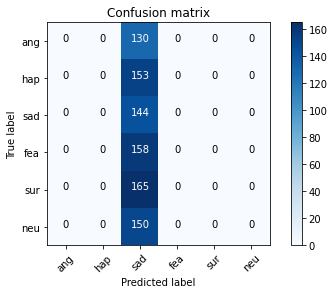

In [173]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='sgd', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

## learning rate

6
Test Set Accuracy =  0.742
Test Set F-score =  0.725
Test Set Precision =  0.729
Test Set Recall =  0.739
Confusion matrix, without normalization
[[120   8   2   0   0   0]
 [ 32  62  24   2   9  24]
 [ 15  11  73   0   1  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  12  32   1   3  90]]


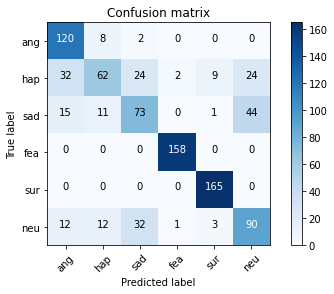

In [240]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.723
Test Set F-score =  0.707
Test Set Precision =  0.711
Test Set Recall =  0.719
Confusion matrix, without normalization
[[105  12   8   0   0   5]
 [ 25  83  25   2   8  10]
 [ 14  18  90   0   2  20]
 [  0   0   0 158   0   0]
 [  5   0   0   0 160   0]
 [ 11  27  49   1   7  55]]


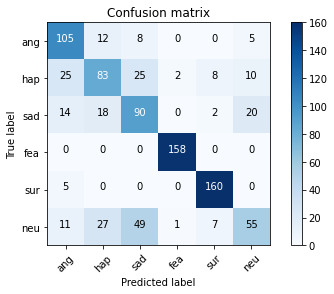

In [132]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='invscaling', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.706
Test Set F-score =  0.687
Test Set Precision =  0.697
Test Set Recall =  0.701
Confusion matrix, without normalization
[[106   5  14   0   2   3]
 [ 31  53  36   1  12  20]
 [ 14  12  90   0   2  26]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  15  58   1   5  63]]


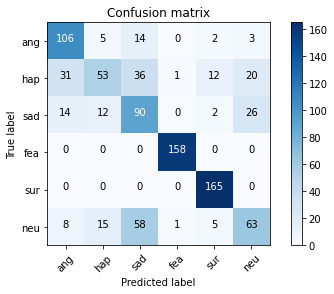

In [241]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

## learning rate init

6
Test Set Accuracy =  0.722
Test Set F-score =  0.708
Test Set Precision =  0.706
Test Set Recall =  0.717
Confusion matrix, without normalization
[[108   7   4   0   0  11]
 [ 27  69  31   0   9  17]
 [ 13  19  76   1   0  35]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 11  20  40   1   4  74]]


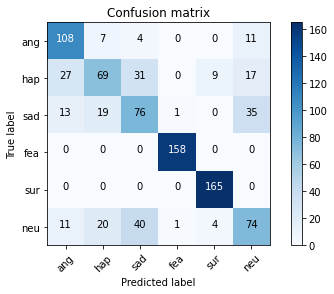

In [191]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.754
Test Set F-score =  0.740
Test Set Precision =  0.739
Test Set Recall =  0.751
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 26  75  18   1  11  22]
 [ 13  14  81   0   3  33]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 13  20  29   1   5  82]]


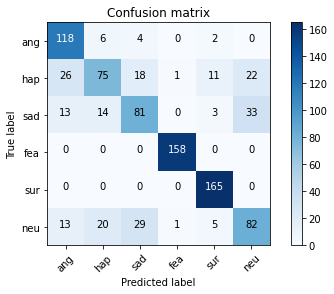

In [202]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.003,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.749
Test Set F-score =  0.735
Test Set Precision =  0.732
Test Set Recall =  0.745
Confusion matrix, without normalization
[[116   4   8   0   2   0]
 [ 18  83  21   0   9  22]
 [ 16  19  76   0   3  30]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 11  26  27   1   9  76]]


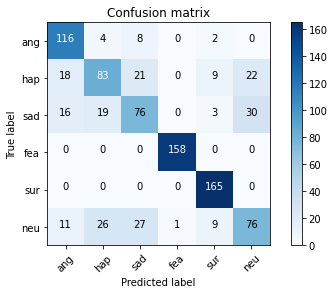

In [192]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.756
Test Set F-score =  0.743
Test Set Precision =  0.739
Test Set Recall =  0.752
Confusion matrix, without normalization
[[120   2   6   0   2   0]
 [ 16  85  21   0   8  23]
 [ 11  22  73   0   2  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  29  26   1   8  79]]


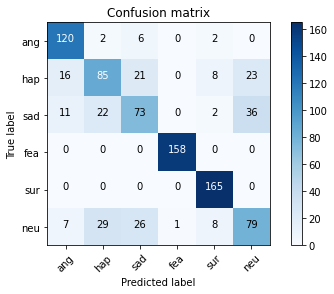

In [56]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.737
Test Set F-score =  0.723
Test Set Precision =  0.724
Test Set Recall =  0.729
Confusion matrix, without normalization
[[ 98  16   4   0   0  12]
 [ 18  73  21   1  10  30]
 [ 14  21  68   0   3  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  14  25   1   5 101]]


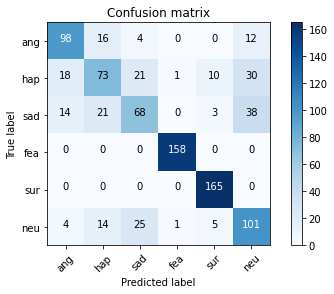

In [57]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0006,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.732
Test Set Precision =  0.732
Test Set Recall =  0.742
Confusion matrix, without normalization
[[115   6   4   0   4   1]
 [ 20  76  30   0   8  19]
 [ 17  14  83   0   1  29]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  20  41   1   2  74]]


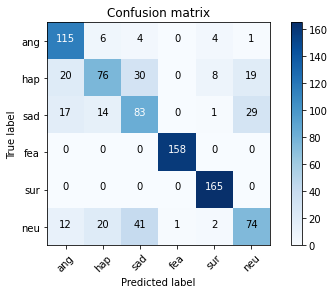

In [193]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0004,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6
Test Set Accuracy =  0.746
Test Set F-score =  0.733
Test Set Precision =  0.733
Test Set Recall =  0.740
Confusion matrix, without normalization
[[109  11   4   0   1   5]
 [ 16  86  13   0  12  26]
 [ 11  17  71   0   3  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  26  22   1  12  82]]


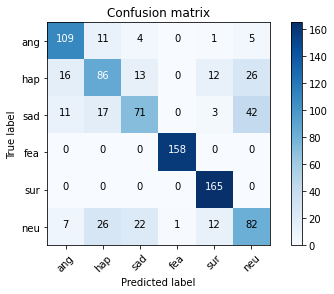

In [194]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0002,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6
Test Set Accuracy =  0.684
Test Set F-score =  0.671
Test Set Precision =  0.671
Test Set Recall =  0.678
Confusion matrix, without normalization
[[ 92  16   8   0   5   9]
 [ 23  73  20   0  17  20]
 [ 20   6  76   1   4  37]
 [  0   0   0 158   0   0]
 [  0   4   7   0 150   4]
 [ 14  19  36   1  13  67]]


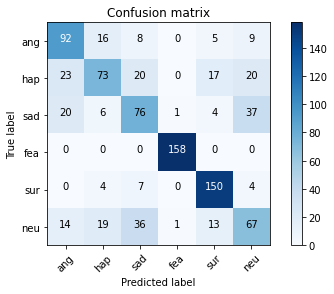

In [195]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0001,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

## Layer size

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


6
Test Set Accuracy =  0.717
Test Set F-score =  0.703
Test Set Precision =  0.700
Test Set Recall =  0.711
Confusion matrix, without normalization
[[105   8   8   0   0   9]
 [ 27  70  29   0   9  18]
 [  9  18  70   0   3  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  26  33   2   5  77]]


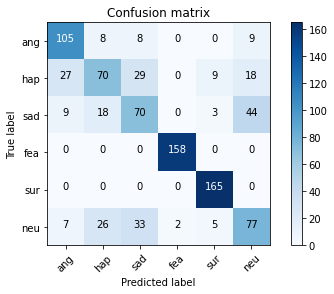

In [62]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.734
Test Set Precision =  0.732
Test Set Recall =  0.743
Confusion matrix, without normalization
[[115   6   2   0   1   6]
 [ 18  85  22   0   7  21]
 [ 18  17  65   0   2  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  27  24   1   6  85]]


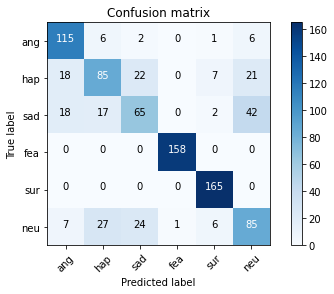

In [63]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.741
Test Set F-score =  0.727
Test Set Precision =  0.724
Test Set Recall =  0.738
Confusion matrix, without normalization
[[120   4   2   0   0   4]
 [ 21  74  23   0   8  27]
 [ 14  16  70   1   2  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  27  31   1   4  80]]


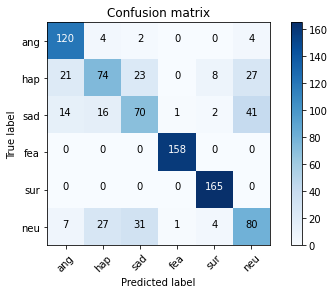

In [64]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(150, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.751
Test Set F-score =  0.739
Test Set Precision =  0.735
Test Set Recall =  0.747
Confusion matrix, without normalization
[[114  10   6   0   0   0]
 [ 13  92  22   0   5  21]
 [ 13  20  75   1   0  35]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  27  34   1   6  72]]


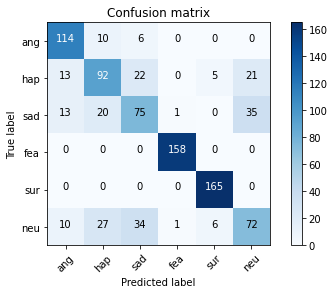

In [65]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(200, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.756
Test Set F-score =  0.745
Test Set Precision =  0.741
Test Set Recall =  0.751
Confusion matrix, without normalization
[[114   8   4   0   2   2]
 [ 12  88  26   0   7  20]
 [ 11  20  77   0   2  34]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  20  36   1   5  78]]


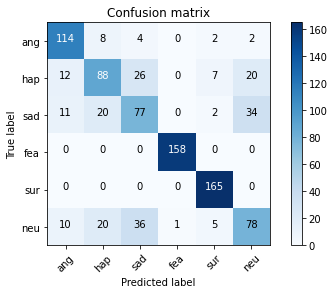

In [242]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(250, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

# BEST MODEL

6
Test Set Accuracy =  0.761
Test Set F-score =  0.751
Test Set Precision =  0.752
Test Set Recall =  0.756
Confusion matrix, without normalization
[[113  13   2   0   2   0]
 [  7 105  16   0   7  18]
 [  9  31  65   0   1  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  37  24   1   3  79]]


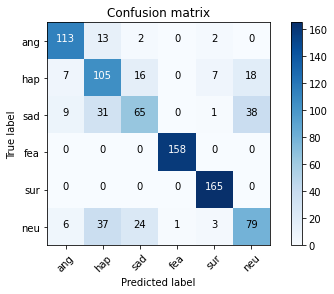

In [59]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

# checking for variance

6
Test Set Accuracy =  0.747
Test Set F-score =  0.731
Test Set Precision =  0.733
Test Set Recall =  0.744
Confusion matrix, without normalization
[[120   2   6   0   2   0]
 [ 24  72  23   0  11  23]
 [ 17  12  80   0   1  34]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 14  18  32   1   8  77]]


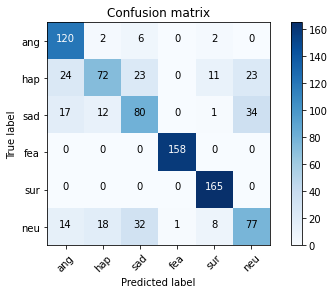

In [301]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.739
Test Set Precision =  0.736
Test Set Recall =  0.748
Confusion matrix, without normalization
[[118   4   4   0   4   0]
 [ 19  84  23   0   5  22]
 [ 15  16  74   0   3  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  20  33   1   8  78]]


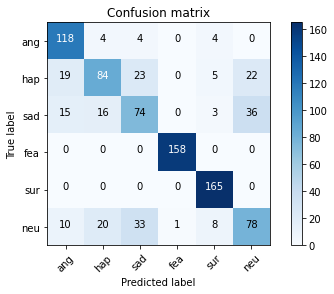

In [302]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.550
Test Set F-score =  0.546
Test Set Precision =  0.594
Test Set Recall =  0.547
Confusion matrix, without normalization
[[ 58  38   6   2   3  23]
 [ 16  81  19   4   8  25]
 [  8  23  71   4   0  38]
 [  0   0   0 158   0   0]
 [  0  32  22   6  52  53]
 [  4  33  32   2   4  75]]


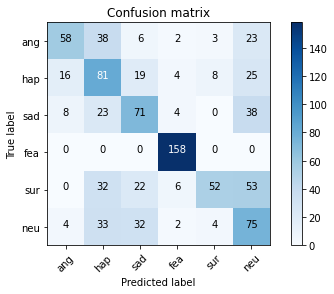

In [312]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.734
Test Set F-score =  0.721
Test Set Precision =  0.716
Test Set Recall =  0.731
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 25  76  25   1   9  17]
 [  7  20  78   0   2  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  33  39   2   2  66]]


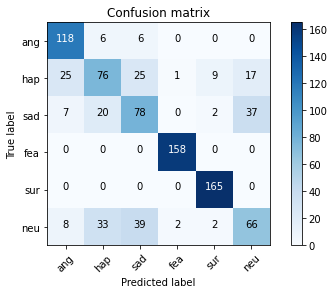

In [311]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='tanh', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.516
Test Set F-score =  0.462
Test Set Precision =  0.519
Test Set Recall =  0.511
Confusion matrix, without normalization
[[ 65   3  24   3  22  13]
 [ 27   3  41   5  64  13]
 [  8   0  90   5  24  17]
 [  0   0   0 158   0   0]
 [ 10   0  22  15 111   7]
 [  7   0  71   5  30  37]]


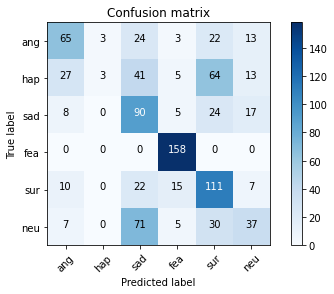

In [313]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='identity', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

# --------------------------------------------------------------------------------

6
Test Set Accuracy =  0.752
Test Set F-score =  0.739
Test Set Precision =  0.736
Test Set Recall =  0.748
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 16  93  20   0   8  16]
 [ 14  25  73   0   1  31]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  31  35   1   5  70]]


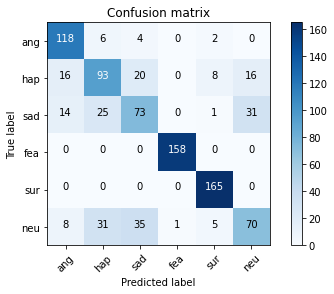

In [60]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(750, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.757
Test Set F-score =  0.744
Test Set Precision =  0.742
Test Set Recall =  0.752
Confusion matrix, without normalization
[[114   8   6   0   2   0]
 [ 12  98  17   0   7  19]
 [ 13  23  67   0   1  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  30  22   0  11  79]]


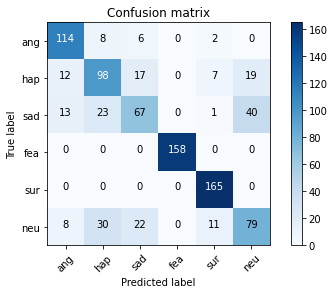

In [61]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(1000, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

#### Support Vector Machine

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.453
Test Set F-score =  0.416
Test Set Precision =  0.533
Test Set Recall =  0.452
Confusion matrix, without normalization
[[ 71  13   0  28   3  15]
 [ 38  39   0  30  24  22]
 [ 20   9  22  40  10  43]
 [  0   0   0 158   0   0]
 [  6  17   0  79  47  16]
 [ 14  14   1  38  12  71]]


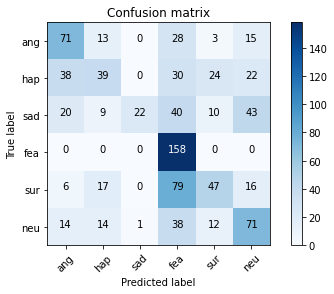

In [325]:
## SVM LINEAR
svc_classifier = LinearSVC()

svc_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred = svc_classifier.predict(X_test_mfcc)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mfcc, pred_onehot)

6
Test Set Accuracy =  0.283
Test Set F-score =  0.233
Test Set Precision =  0.259
Test Set Recall =  0.285
Confusion matrix, without normalization
[[ 50   8   3  58  11   0]
 [ 29   8  20  82  14   0]
 [ 12   9  51  62  10   0]
 [ 17   0   0 121  20   0]
 [ 21   3   8 108  25   0]
 [ 12   5  36  91   6   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


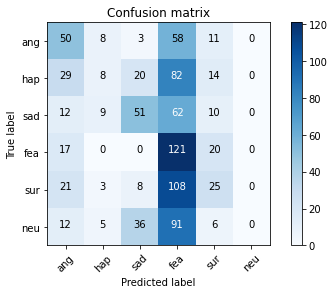

In [254]:
## SVM NON-LINEAR
svc_classifier = SVC(kernel = 'poly')

svc_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred = svc_classifier.predict(X_test_mfcc)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mfcc, pred_onehot)

6
Test Set Accuracy =  0.122
Test Set F-score =  0.048
Test Set Precision =  0.057
Test Set Recall =  0.140
Confusion matrix, without normalization
[[104   0   4  22   0   0]
 [136   0   2  15   0   0]
 [130   0   6   8   0   0]
 [158   0   0   0   0   0]
 [147   0  11   7   0   0]
 [141   0   5   4   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


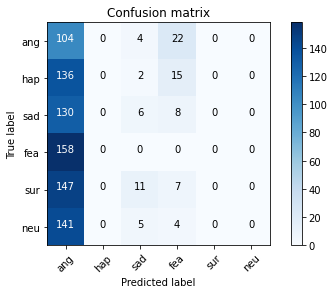

In [249]:
## SVM SIGMOID
svc_classifier = SVC(kernel = 'sigmoid')

svc_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred = svc_classifier.predict(X_test_mfcc)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mfcc, pred_onehot)

6
Test Set Accuracy =  0.289
Test Set F-score =  0.227
Test Set Precision =  0.223
Test Set Recall =  0.291
Confusion matrix, without normalization
[[ 57   0   6  58   9   0]
 [ 40   0  19  80  14   0]
 [ 23   0  50  64   7   0]
 [ 17   0   0 121  20   0]
 [ 24   0   8 101  32   0]
 [ 16   0  39  90   5   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


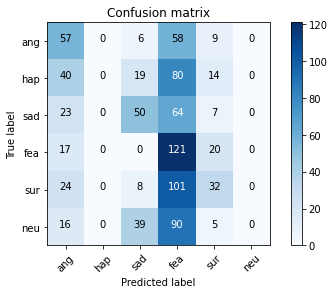

In [250]:
## SVM SGD
svc_classifier = SVC(kernel = 'rbf')

svc_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred = svc_classifier.predict(X_test_mfcc)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mfcc, pred_onehot)

#### Logistic Regression

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


6
Test Set Accuracy =  0.540
Test Set F-score =  0.521
Test Set Precision =  0.514
Test Set Recall =  0.537
Confusion matrix, without normalization
[[ 78  27   3   4   9   9]
 [ 38  41  19   9  31  15]
 [ 17  11  62   7  14  33]
 [  0   0   0 158   0   0]
 [ 10  11   9  22  94  19]
 [ 17  23  38   4  15  53]]


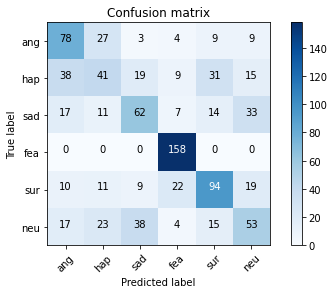

In [178]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


6
Test Set Accuracy =  0.546
Test Set F-score =  0.520
Test Set Precision =  0.515
Test Set Recall =  0.541
Confusion matrix, without normalization
[[ 79  22   5   3  12   9]
 [ 39  35  16   9  38  16]
 [ 18   9  63   6  17  31]
 [  0   0   0 158   0   0]
 [ 10   3   6  22 109  15]
 [ 15  23  40   6  19  47]]


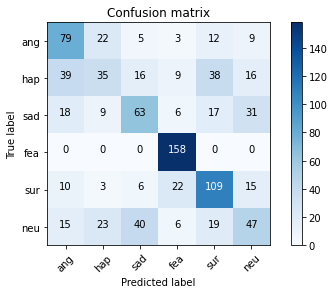

In [179]:
lr_classifier = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


6
Test Set Accuracy =  0.543
Test Set F-score =  0.513
Test Set Precision =  0.513
Test Set Recall =  0.539
Confusion matrix, without normalization
[[ 80  15   5   7  15   8]
 [ 39  34  16   9  39  16]
 [ 21   6  65   7  18  27]
 [  0   0   0 158   0   0]
 [ 10   4   6  22 111  12]
 [ 14  21  44   7  23  41]]


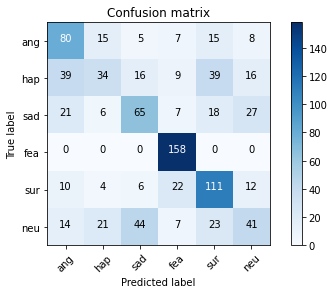

In [180]:
lr_classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


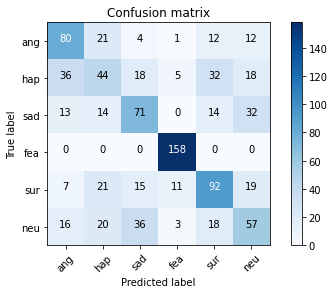

In [181]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

##### Max Iter?


6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


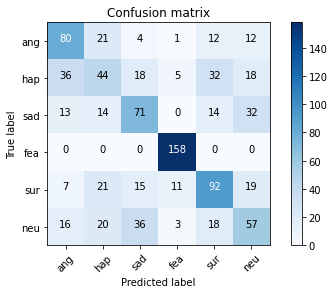

In [196]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


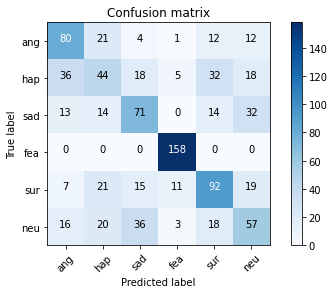

In [197]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


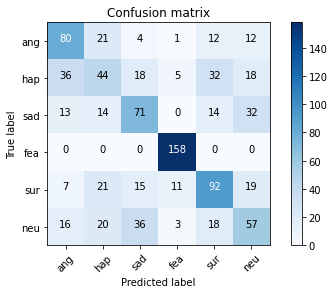

In [198]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=1500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


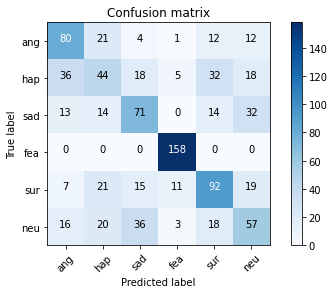

In [199]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=2000)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


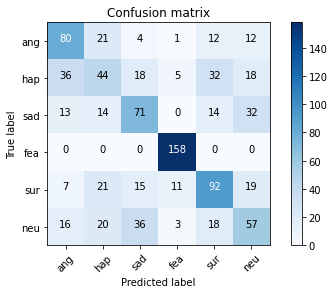

In [200]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=2500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results

display_results(y_test_mfcc, pred_probs)

## BEST MODEL

6
Test Set Accuracy =  0.558
Test Set F-score =  0.545
Test Set Precision =  0.539
Test Set Recall =  0.556
Confusion matrix, without normalization
[[ 80  21   4   1  12  12]
 [ 36  44  18   5  32  18]
 [ 13  14  71   0  14  32]
 [  0   0   0 158   0   0]
 [  7  21  15  11  92  19]
 [ 16  20  36   3  18  57]]


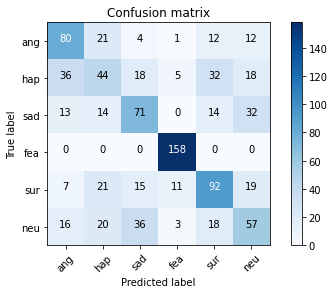

In [182]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

## MEL

We use Mel-spectrogram as input features.

#### Random Forest Classifier

In [ ]:
## Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=50, min_samples_split=10)
rf_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = rf_classifier.predict_proba(X_test_mel)
# Results
display_results(y_test_mel, pred_probs)

#### XGB Classifier

In [ ]:
## XGB Classifier
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.005, objective='multi:softprob', 
                                   n_estimators=100, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=5)
xgb_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = xgb_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

#### MLP Classifier

6
Test Set Accuracy =  0.659
Test Set F-score =  0.637
Test Set Precision =  0.631
Test Set Recall =  0.653
Confusion matrix, without normalization
[[107  13   4   0   2   4]
 [ 30  64  34   0   3  22]
 [ 25  27  53   1   4  34]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  26  57   3   9  46]]


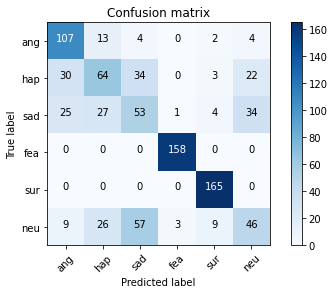

In [66]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)


# Best model for MFCC does not perform well with Mel

6
Test Set Accuracy =  0.484
Test Set F-score =  0.455
Test Set Precision =  0.459
Test Set Recall =  0.479
Confusion matrix, without normalization
[[ 59  22   8  15  14  12]
 [ 28  46  11  16  20  32]
 [ 14  21  26  18  17  48]
 [  0   0   0 158   0   0]
 [ 16  31  11  11  68  28]
 [ 25  11  12   9  14  79]]


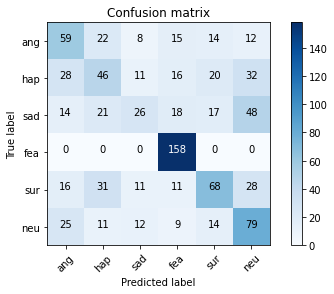

In [131]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(250, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

# Activation

6
Test Set Accuracy =  0.626
Test Set F-score =  0.609
Test Set Precision =  0.613
Test Set Recall =  0.622
Confusion matrix, without normalization
[[109   7   4   0   4   6]
 [ 31  70  22   0   5  25]
 [ 24  32  42   2   2  42]
 [  0   0   0 139  19   0]
 [  3   4   4   0 143  11]
 [ 26  34  19   1  10  60]]


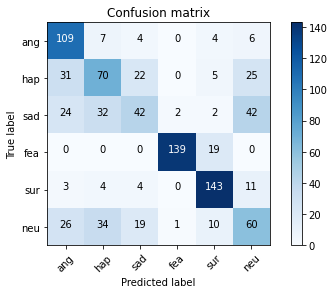

In [69]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.460
Test Set F-score =  0.456
Test Set Precision =  0.471
Test Set Recall =  0.456
Confusion matrix, without normalization
[[ 60  23   7   1  15  24]
 [ 32  48   8   7  16  42]
 [ 17  18  36   3  19  51]
 [  0   0   0 139   0  19]
 [ 24  22   8   4  66  41]
 [ 19  12  36   2  16  65]]


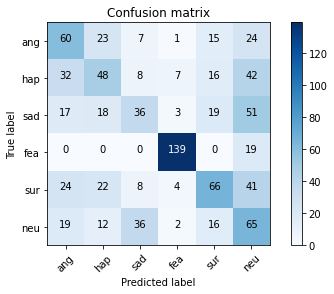

In [70]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='identity', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.138
Test Set F-score =  0.098
Test Set Precision =  0.195
Test Set Recall =  0.136
Confusion matrix, without normalization
[[ 2 15 58 54  0  1]
 [ 1 22 53 75  1  1]
 [12 37 37 58  0  0]
 [ 0  0 99 59  0  0]
 [ 0 19 53 89  4  0]
 [ 6 57 30 56  1  0]]


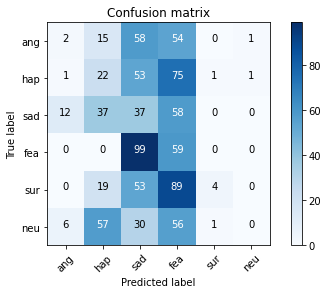

In [71]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.103
Test Set F-score =  0.102
Test Set Precision =  0.111
Test Set Recall =  0.102
Confusion matrix, without normalization
[[14 43  8 25 36  4]
 [16 29  8 45 46  9]
 [18 40 11 35 34  6]
 [37  0 45  0 59 17]
 [ 8 42  8 55 31 21]
 [ 7 32 12 57 34  8]]


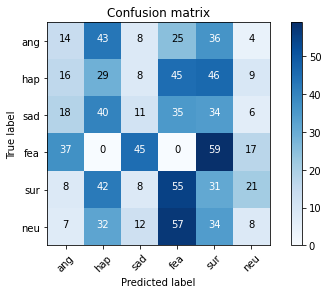

In [72]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='tanh', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

# Best Solver

6
Test Set Accuracy =  0.668
Test Set F-score =  0.653
Test Set Precision =  0.650
Test Set Recall =  0.663
Confusion matrix, without normalization
[[103   8  11   1   4   3]
 [ 25  63  33   1  11  20]
 [ 18  21  68   0   1  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 155  10]
 [ 13  24  52   1   6  54]]


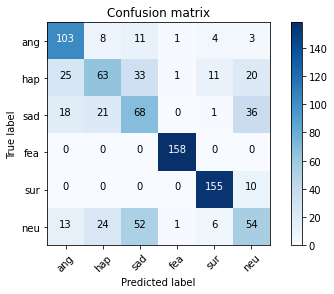

In [73]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


6
Test Set Accuracy =  0.163
Test Set F-score =  0.102
Test Set Precision =  0.196
Test Set Recall =  0.167
Confusion matrix, without normalization
[[  0  11  95  18   6   0]
 [  0   6 118  22   5   2]
 [  0   2 110  20   9   3]
 [  0   0 142  16   0   0]
 [  0  11 130  15   5   4]
 [  1   4 112  19   4  10]]


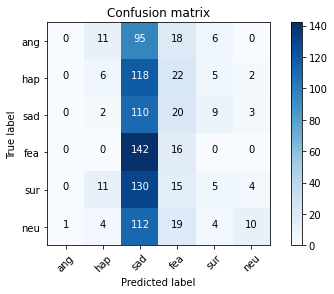

In [74]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='lbfgs', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.144
Test Set F-score =  0.042
Test Set Precision =  0.024
Test Set Recall =  0.167
Confusion matrix, without normalization
[[130   0   0   0   0   0]
 [152   0   0   1   0   0]
 [144   0   0   0   0   0]
 [158   0   0   0   0   0]
 [165   0   0   0   0   0]
 [149   0   1   0   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


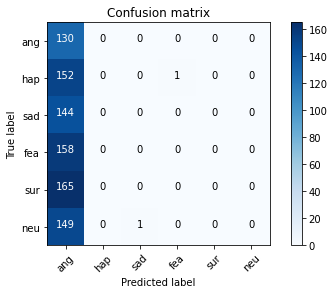

In [75]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='sgd', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

# Learning Rate - Notes : All learning rates give more or less the same results

6
Test Set Accuracy =  0.696
Test Set F-score =  0.684
Test Set Precision =  0.685
Test Set Recall =  0.691
Confusion matrix, without normalization
[[107  17   4   0   2   0]
 [ 20  90  23   1   5  14]
 [ 15  33  54   1   3  38]
 [  0   0   0 158   0   0]
 [  3  10   0   0 148   4]
 [  7  39  30   3   2  69]]


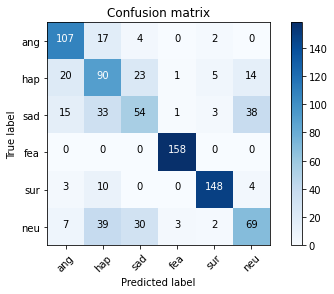

In [91]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.649
Test Set F-score =  0.626
Test Set Precision =  0.626
Test Set Recall =  0.642
Confusion matrix, without normalization
[[103  12   7   0   3   5]
 [ 38  67  20   3   2  23]
 [ 24  40  39   1   3  37]
 [  0   0   0 158   0   0]
 [  6   0   5   0 154   0]
 [ 19  35  16   0  17  63]]


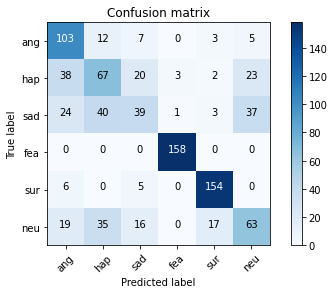

In [92]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='invscaling', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.702
Test Set F-score =  0.686
Test Set Precision =  0.681
Test Set Recall =  0.696
Confusion matrix, without normalization
[[108   9   5   0   2   6]
 [ 20  72  31   1   4  25]
 [ 21  29  55   0   1  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 13  22  36   1   4  74]]


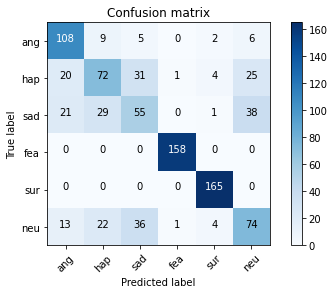

In [93]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

# learning rate init

6
Test Set Accuracy =  0.672
Test Set F-score =  0.652
Test Set Precision =  0.646
Test Set Recall =  0.666
Confusion matrix, without normalization
[[105   8   9   0   3   5]
 [ 23  55  39   3   7  26]
 [ 17  27  56   1   6  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 14  19  40   2   9  66]]


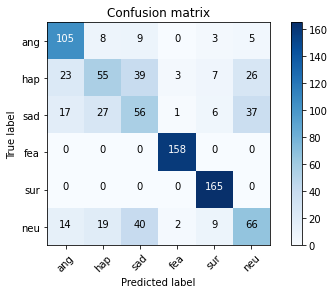

In [238]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.0001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.681
Test Set F-score =  0.662
Test Set Precision =  0.656
Test Set Recall =  0.675
Confusion matrix, without normalization
[[108  12   6   0   0   4]
 [ 21  60  29   1  13  29]
 [ 19  23  57   0   6  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  19  45   2   9  65]]


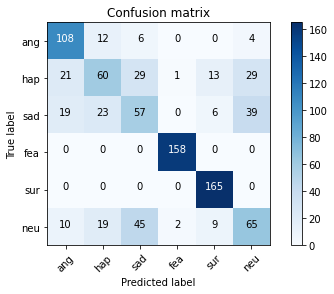

In [222]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.0002,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.673
Test Set F-score =  0.654
Test Set Precision =  0.649
Test Set Recall =  0.668
Confusion matrix, without normalization
[[110  10   6   0   4   0]
 [ 21  59  41   1   5  26]
 [ 22  24  64   0   1  33]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 15  32  47   1   5  50]]


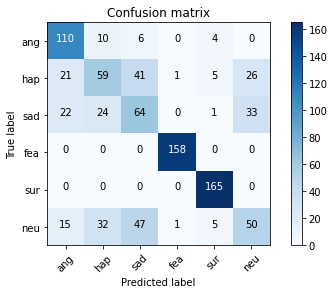

In [233]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.0004,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.657
Test Set F-score =  0.643
Test Set Precision =  0.652
Test Set Recall =  0.651
Confusion matrix, without normalization
[[109  17   0   0   0   4]
 [ 20  75  19   3   7  29]
 [ 13  33  36   0   5  57]
 [  0  28   0 130   0   0]
 [  0   0   0   0 165   0]
 [ 10  36  21   3   4  76]]


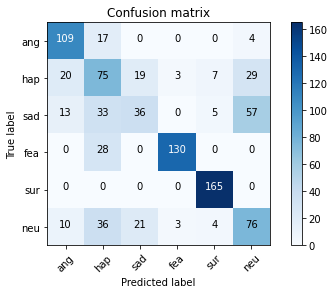

In [231]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.0006,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.674
Test Set F-score =  0.641
Test Set Precision =  0.644
Test Set Recall =  0.669
Confusion matrix, without normalization
[[117   2   4   0   1   6]
 [ 28  50  19   0  11  45]
 [ 21  25  31   0  10  57]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 14  22  17   1  10  86]]


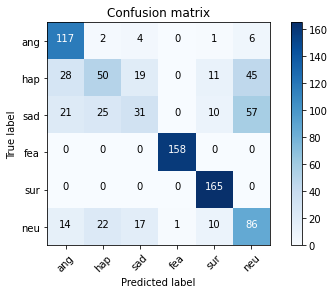

In [232]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.706
Test Set F-score =  0.694
Test Set Precision =  0.694
Test Set Recall =  0.700
Confusion matrix, without normalization
[[105  13   8   0   0   4]
 [ 16  84  32   0   6  15]
 [ 17  25  68   1   5  28]
 [  0   0   0 158   0   0]
 [  2   2   6   0 155   0]
 [  8  26  41   1   9  65]]


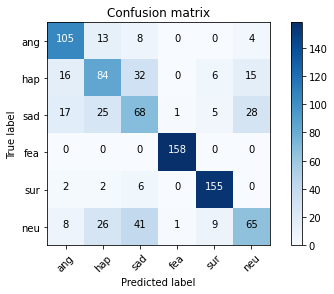

In [237]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.654
Test Set F-score =  0.637
Test Set Precision =  0.657
Test Set Recall =  0.647
Confusion matrix, without normalization
[[ 95  23  10   0   0   2]
 [ 18  91  32   1   2   9]
 [ 16  45  62   1   3  17]
 [  0   0   0 158   0   0]
 [  0   6   5   0 154   0]
 [  8  55  57   1   0  29]]


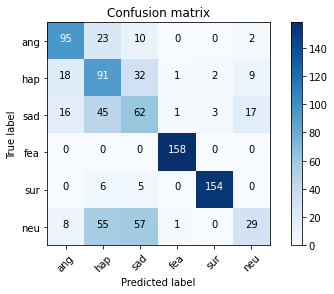

In [236]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.003,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.640
Test Set F-score =  0.627
Test Set Precision =  0.634
Test Set Recall =  0.634
Confusion matrix, without normalization
[[ 96  26   4   0   1   3]
 [ 37  63  20   0   3  30]
 [ 17  37  49   1   4  36]
 [  0   0   0 158   0   0]
 [ 12   6   0   0 147   0]
 [ 12  47  20   2   6  63]]


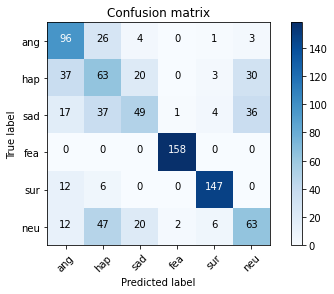

In [228]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.509
Test Set F-score =  0.493
Test Set Precision =  0.569
Test Set Recall =  0.509
Confusion matrix, without normalization
[[109  15   2   2   0   2]
 [ 86  30   9   2   8  18]
 [ 67   7  32   2   7  29]
 [ 16   0   0 142   0   0]
 [ 57   0   0   0 108   0]
 [ 65  22  20   2   4  37]]


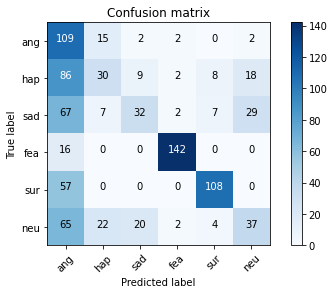

In [229]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.007,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.339
Test Set F-score =  0.327
Test Set Precision =  0.604
Test Set Recall =  0.334
Confusion matrix, without normalization
[[ 21   5   0   0   0 104]
 [  9  14   8   1   2 119]
 [  5   5  15   3   2 114]
 [  0   0   0  65   0  93]
 [  0   0   0   0  55 110]
 [  2   2   7   2   2 135]]


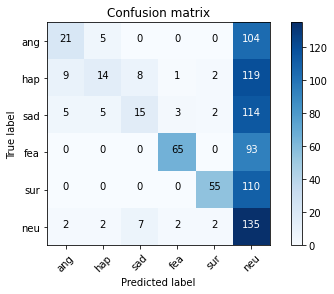

In [150]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

# Layer Size

6
Test Set Accuracy =  0.622
Test Set F-score =  0.601
Test Set Precision =  0.596
Test Set Recall =  0.613
Confusion matrix, without normalization
[[ 89  22   2   2   3  12]
 [ 21  63  28   1   7  33]
 [ 21  30  37   4   7  45]
 [  0   0   0 158   0   0]
 [  0   9   0   0 156   0]
 [ 18  39  27   3   6  57]]


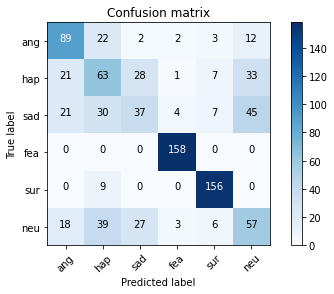

In [161]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.664
Test Set F-score =  0.650
Test Set Precision =  0.649
Test Set Recall =  0.659
Confusion matrix, without normalization
[[102   7  10   0   4   7]
 [ 26  54  32   2   8  31]
 [ 15  19  58   0   7  45]
 [  0   0   0 158   0   0]
 [  0   0   1   0 153  11]
 [ 12  23  38   1   3  73]]


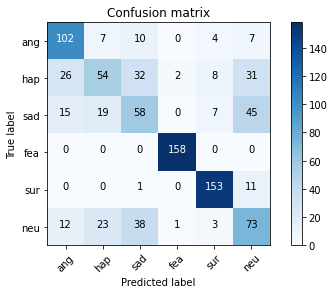

In [162]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.673
Test Set F-score =  0.652
Test Set Precision =  0.647
Test Set Recall =  0.667
Confusion matrix, without normalization
[[106  14   8   0   2   0]
 [ 26  63  26   0  13  25]
 [ 19  31  57   1   5  31]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 14  34  34   1  10  57]]


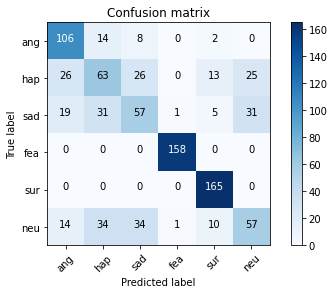

In [163]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(150, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.670
Test Set F-score =  0.648
Test Set Precision =  0.640
Test Set Recall =  0.663
Confusion matrix, without normalization
[[104  11   4   0   7   4]
 [ 25  66  30   2   4  26]
 [ 23  29  47   3   6  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  35  33   1   9  63]]


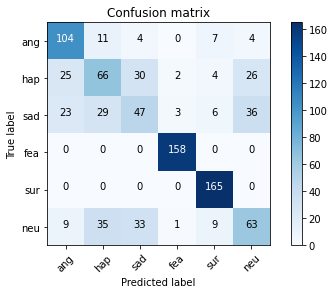

In [164]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(200, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.682
Test Set F-score =  0.669
Test Set Precision =  0.665
Test Set Recall =  0.675
Confusion matrix, without normalization
[[101   9   8   0   0  12]
 [ 21  59  32   1   6  34]
 [ 14  26  57   0   4  43]
 [  0   0   0 158   0   0]
 [  0   0   0   0 163   2]
 [  9  27  36   0   2  76]]


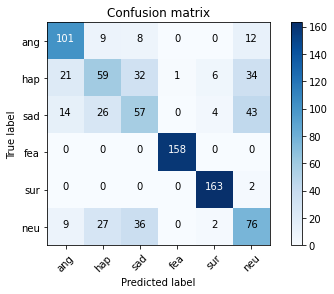

In [165]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(250, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.674
Test Set F-score =  0.659
Test Set Precision =  0.656
Test Set Recall =  0.667
Confusion matrix, without normalization
[[101  15   6   0   0   8]
 [ 22  64  29   1   7  30]
 [ 12  32  43   0   2  55]
 [  0   0   0 158   0   0]
 [  0   0   0   0 160   5]
 [ 10  23  32   1   3  81]]


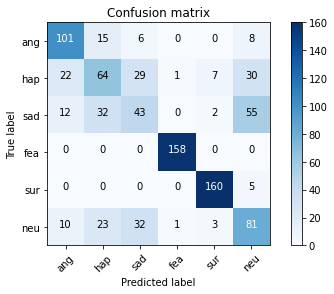

In [166]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(300, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.687
Test Set F-score =  0.657
Test Set Precision =  0.655
Test Set Recall =  0.682
Confusion matrix, without normalization
[[120   6   2   0   0   2]
 [ 26  66  21   0  11  29]
 [ 29  24  34   0   6  51]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 18  26  22   2   7  75]]


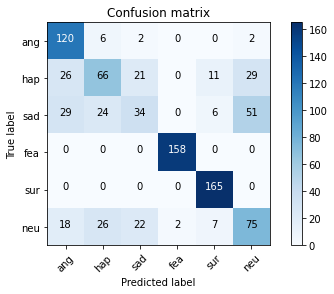

In [167]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(350, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.682
Test Set F-score =  0.661
Test Set Precision =  0.659
Test Set Recall =  0.675
Confusion matrix, without normalization
[[107  12   5   0   4   2]
 [ 20  81  22   2   9  19]
 [ 20  42  49   1   4  28]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  45  32   0   7  54]]


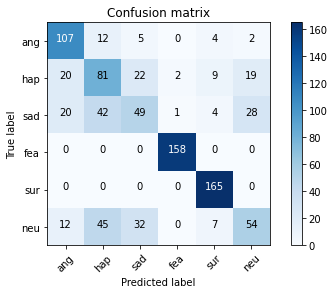

In [168]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(400, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

6
Test Set Accuracy =  0.700
Test Set F-score =  0.683
Test Set Precision =  0.678
Test Set Recall =  0.694
Confusion matrix, without normalization
[[112  12   2   0   0   4]
 [ 19  72  29   0   5  28]
 [ 21  23  50   0   2  48]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 11  28  34   0   4  73]]


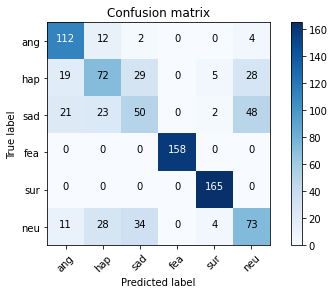

In [169]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(450, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

# Best Model

6
Test Set Accuracy =  0.706
Test Set F-score =  0.679
Test Set Precision =  0.689
Test Set Recall =  0.699
Confusion matrix, without normalization
[[108   6   5   0   6   5]
 [ 17  60  24   2  11  39]
 [ 15  15  38   0  10  66]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 11  11  17   0   5 106]]


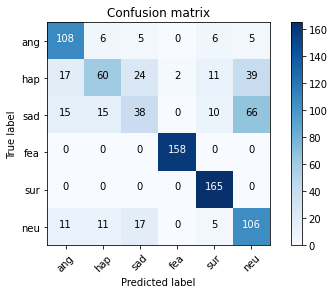

In [170]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

#### Support Vector Machines

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.491
Test Set F-score =  0.466
Test Set Precision =  0.496
Test Set Recall =  0.479
Confusion matrix, without normalization
[[ 35  24   5   0  50  16]
 [  8  50  12   3  35  45]
 [ 10  25  25   4  21  59]
 [  0   0   0 158   0   0]
 [  7  20   5   4  95  34]
 [  7  21  13   1  29  79]]


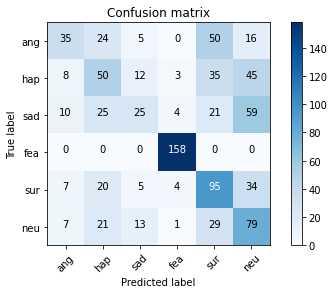

In [183]:
## SVM LINEAR
svc_classifier = LinearSVC()

svc_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred = svc_classifier.predict(X_test_mel)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mel, pred_onehot)

6
Test Set Accuracy =  0.430
Test Set F-score =  0.444
Test Set Precision =  0.633
Test Set Recall =  0.423
Confusion matrix, without normalization
[[ 39  86   2   0   0   3]
 [  6 122   9   0   4  12]
 [  5  96  24   0   2  17]
 [  0  52   0 106   0   0]
 [  0  99   4   0  61   1]
 [  3  94  17   0   1  35]]


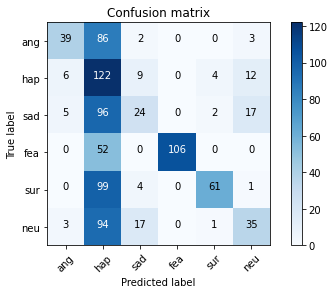

In [184]:
## SVM Poly
svc_classifier = SVC(kernel = 'poly')

svc_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred = svc_classifier.predict(X_test_mel)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mel, pred_onehot)

6
Test Set Accuracy =  0.337
Test Set F-score =  0.327
Test Set Precision =  0.342
Test Set Recall =  0.333
Confusion matrix, without normalization
[[ 25  55  11  10  15  14]
 [ 12  79  13  17  20  12]
 [ 12  40  42   5  22  23]
 [  0  23  17 102   0  16]
 [ 22  68  13   6  24  32]
 [  8  37  38   4  32  31]]


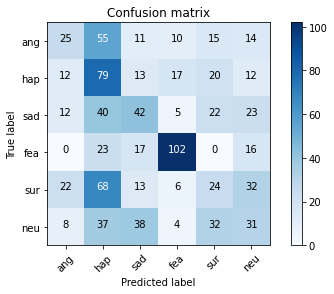

In [185]:
## SVM Sigmoid
svc_classifier = SVC(kernel = 'sigmoid')

svc_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred = svc_classifier.predict(X_test_mel)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mel, pred_onehot)

6
Test Set Accuracy =  0.571
Test Set F-score =  0.566
Test Set Precision =  0.577
Test Set Recall =  0.565
Confusion matrix, without normalization
[[ 71  33  11   2   4   9]
 [ 30  69  18   4   5  27]
 [ 15  36  54   3   8  28]
 [  0   0   0 158   0   0]
 [ 15  27  16   4 101   2]
 [ 12  33  38   2   4  61]]


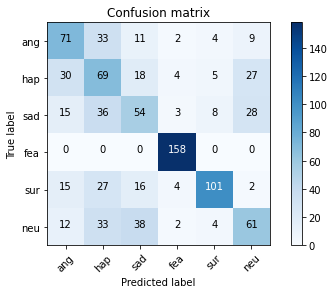

In [263]:
## SVM NON-LINEAR
svc_classifier = SVC(kernel = 'rbf')

svc_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred = svc_classifier.predict(X_test_mel)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mel, pred_onehot)


#### Logistic Regression 

#### Testing best Optimization Algorithm

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


6
Test Set Accuracy =  0.579
Test Set F-score =  0.563
Test Set Precision =  0.559
Test Set Recall =  0.573
Confusion matrix, without normalization
[[ 84  19   8   0  12   7]
 [ 30  57  19   4  15  28]
 [ 18  24  42   3  14  43]
 [  0   0   0 158   0   0]
 [ 13  12   8   0 119  13]
 [ 11  18  34   1  25  61]]


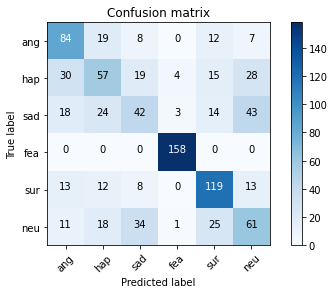

In [187]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


6
Test Set Accuracy =  0.521
Test Set F-score =  0.508
Test Set Precision =  0.504
Test Set Recall =  0.515
Confusion matrix, without normalization
[[ 64  22  12   1  22   9]
 [ 26  54  17   6  18  32]
 [ 17  21  45   5  17  39]
 [  0   0   0 158   0   0]
 [ 17  24  17   4  89  14]
 [ 10  18  36   3  24  59]]


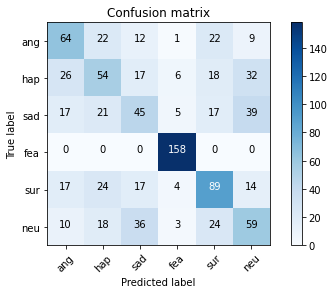

In [188]:
lr_classifier = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


6
Test Set Accuracy =  0.517
Test Set F-score =  0.504
Test Set Precision =  0.500
Test Set Recall =  0.511
Confusion matrix, without normalization
[[ 61  22  12   1  22  12]
 [ 24  54  18   7  17  33]
 [ 15  23  48   5  16  37]
 [  0   0   0 158   0   0]
 [ 21  23  19   4  84  14]
 [ 11  17  34   4  24  60]]


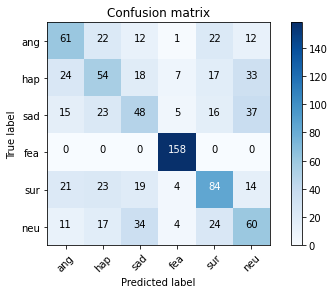

In [189]:

lr_classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 80  21  10   0  10   9]
 [ 27  60  24   4  11  27]
 [ 22  18  46   4  14  40]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  33   3  24  64]]


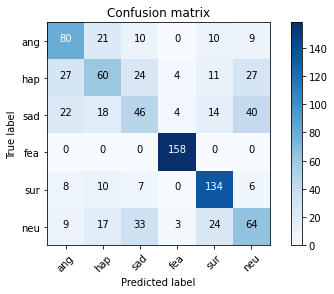

In [190]:

lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

#### best Max Iter

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.599
Test Set F-score =  0.581
Test Set Precision =  0.576
Test Set Recall =  0.591
Confusion matrix, without normalization
[[ 80  21  10   0  12   7]
 [ 27  60  22   4  12  28]
 [ 22  19  46   3  14  40]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [ 10  18  34   3  24  61]]


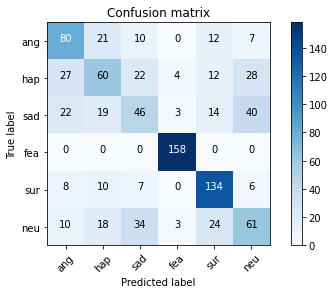

In [203]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=250)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 80  21  10   0  10   9]
 [ 27  60  24   4  11  27]
 [ 22  18  46   4  14  40]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  33   3  24  64]]


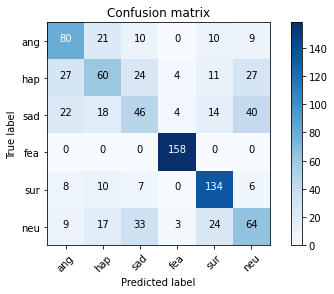

In [204]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 80  20   9   0  10  11]
 [ 27  59  24   4  11  28]
 [ 22  18  47   4  15  38]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  33   3  24  64]]


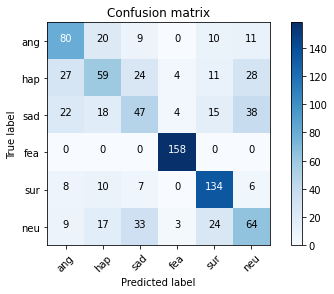

In [205]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=750)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 79  20   9   0  11  11]
 [ 27  58  24   4  12  28]
 [ 22  19  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


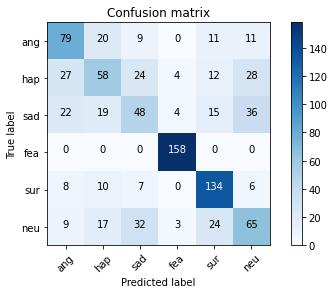

In [206]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 79  20  10   0  10  11]
 [ 27  58  25   4  12  27]
 [ 22  19  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


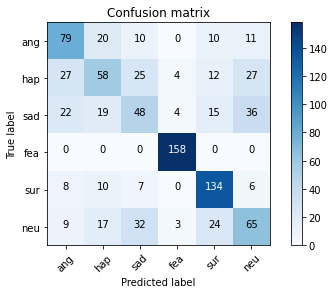

In [207]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=1250)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 79  20  10   0  10  11]
 [ 27  58  25   4  12  27]
 [ 22  19  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


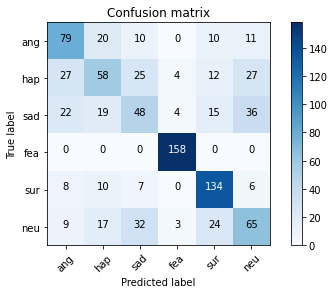

In [208]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=1500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.579
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 80  19  10   0  10  11]
 [ 28  57  25   4  12  27]
 [ 22  19  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


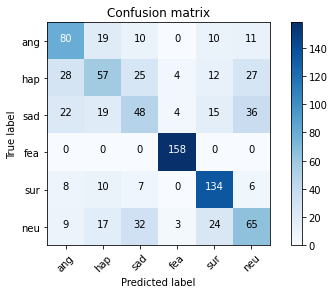

In [209]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=1750)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.603
Test Set F-score =  0.585
Test Set Precision =  0.580
Test Set Recall =  0.596
Confusion matrix, without normalization
[[ 80  19  10   0  10  11]
 [ 28  58  24   4  12  27]
 [ 21  20  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


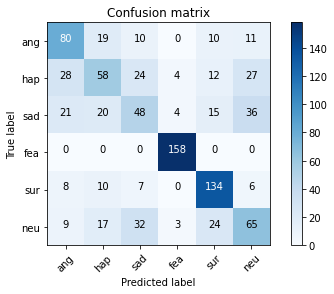

In [210]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=2000)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.603
Test Set F-score =  0.585
Test Set Precision =  0.581
Test Set Recall =  0.596
Confusion matrix, without normalization
[[ 80  19  10   0  10  11]
 [ 27  58  24   4  12  28]
 [ 21  20  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


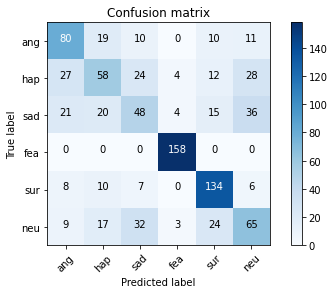

In [211]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=2500)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.603
Test Set F-score =  0.585
Test Set Precision =  0.581
Test Set Recall =  0.596
Confusion matrix, without normalization
[[ 80  19  10   0  10  11]
 [ 27  58  24   4  12  28]
 [ 21  20  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  32   3  24  65]]


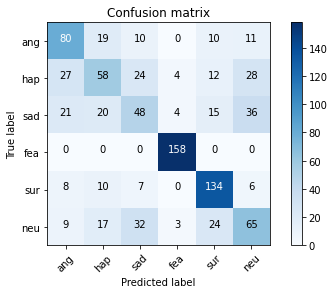

In [212]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=2750)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.602
Test Set F-score =  0.584
Test Set Precision =  0.580
Test Set Recall =  0.594
Confusion matrix, without normalization
[[ 80  19  10   0  10  11]
 [ 28  57  24   4  12  28]
 [ 21  20  48   4  15  36]
 [  0   0   0 158   0   0]
 [  8  10   7   0 134   6]
 [  9  17  33   2  24  65]]


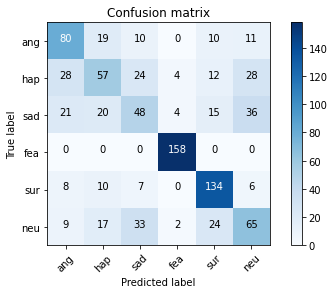

In [213]:
lr_classifier = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=3000)

lr_classifier.fit(X_train_mel, y_train_mel)

# Predict
pred_probs = lr_classifier.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs)